In [6]:
from typing import List, Tuple
import numpy as np
from numpy import ndarray
from enum import Enum

from typing import Callable


class BinMode(Enum):
    percentiles = 0
    linear = 1


def get_percentiles(array: ndarray, num_percentiles: int = 10) -> ndarray:
    """get percentiles with evenly such that the data fits in evenly distributed buckets

    Args:
        array (ndarray): data with shape [num_samples]. All samples with the same features you want to have the percentiles of
        num_percentiles (int, optional): How many percentiles you want to have. Defaults to 10.

    Returns:
        ndarray: percentiles [num_percentiles + 1]
    """
    percentiles = np.linspace(0, 100, num=num_percentiles + 1)
    packed_array = np.percentile(array, percentiles)
    return packed_array


def get_linear_buckets(array: ndarray, num_buckets: int = 10) -> ndarray:
    _, buckets = np.histogram(array, bins=num_buckets)
    return buckets


def get_1d_bucket_index(
    data: ndarray, bucket_func: Callable, num_buckets: int = 10 
) -> Tuple[ndarray, ndarray]:
    """return for each sample in which bucket it belongs

    Args:
        data (ndarray): data column you want to operate on
        num_buckets (int, optional): How many buckets you want to look at. Defaults to 10.

    Returns:
        Tuple[ndarray, ndarray]: indices for each samples in which bucket it belongs [num_samples], bucket boundaries [num_buckets + 1]
    """
    # force data into a float64 format
    data = np.array(data,dtype='float64')
    
    bins = bucket_func(data, num_buckets)

    # subtract -1 because the bins begin at 1
    indices = np.digitize(data, bins) - 1

    # pack maximum element(s) into the last bin
    max_index = np.argwhere(indices == num_buckets)
    indices[max_index] = num_buckets - 1

    return indices, bins


def sort_into_1d_buckets(data: ndarray, indices: ndarray) -> List[ndarray]:
    """sort given data into given buckets

    Args:
        data (ndarray): data you want to split into buckets [num_samples, num_features]
        indices (ndarray): for each sample the index [num_samples]

    Returns:
        List[ndarray]: List of len(unique(indices)) many ndarrays. In each ndarray are the sorted samples.
    """
    num_indices = np.max(indices) + 1
    result = [[]] * num_indices
    for idx in range(num_indices):
        result[idx] = data[np.where(indices == idx)]
    return result


def sort_into_2d_buckets(
    X: ndarray, columns: Tuple[int], bucket_func: Callable, num_percentiles: int = 10
) -> Tuple[List[List[ndarray]], ndarray]:
    """pack data into 2d buckets

    Args:
        X (ndarray): X
        columns (Tuple[int]): _description_
        num_percentiles (int): _description_

    Returns:
        Tuple[List[List[ndarray]], ndarray]: data put into the 2d buckets
    """
    # TODO: do this recursively
    first_column, second_column = columns

    # sort into first bucket
    first_bucket_index, first_order_percentiles = get_1d_bucket_index(
        X[:, first_column], bucket_func, num_percentiles
    )
    packed_data = sort_into_1d_buckets(X, first_bucket_index)
    [print(column.shape) for column in packed_data]

    second_order_bins = bucket_func(X[:, second_column], num_percentiles)
    
    bins = np.stack([first_order_percentiles, second_order_bins])

    bucket_2d = []
    for bucket_content in packed_data:
        second_order_bucket_index = np.digitize(
            bucket_content[:, 1], second_order_bins
        ) - 1
        
        max_max_idx = np.argwhere(second_order_bucket_index == num_percentiles)
        second_order_bucket_index[max_max_idx] = num_percentiles - 1
        
        bucket_2d.append(sort_into_1d_buckets(bucket_content, second_order_bucket_index))

    return bucket_2d, bins


(64, 2)
(64, 2)
(64, 2)
(64, 2)


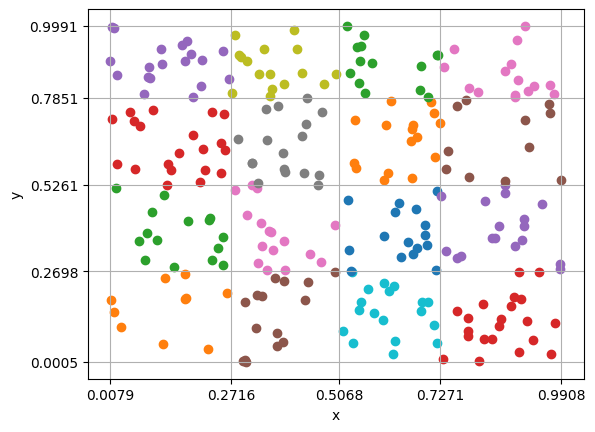

In [7]:
from matplotlib import pyplot as plt


a = np.random.random((256, 2))

plt.scatter(*a.T, s=3)

packed_data, grid = sort_into_2d_buckets(a, [0, 1], get_percentiles, 4)

plt.xticks(grid[0])
plt.xlabel("x")
plt.yticks(grid[1])
plt.ylabel("y")
plt.grid()

for column in packed_data:
    for cell in column:
        pass
        # print(len(cell))
        plt.scatter(*cell.T)
    # print("_____")

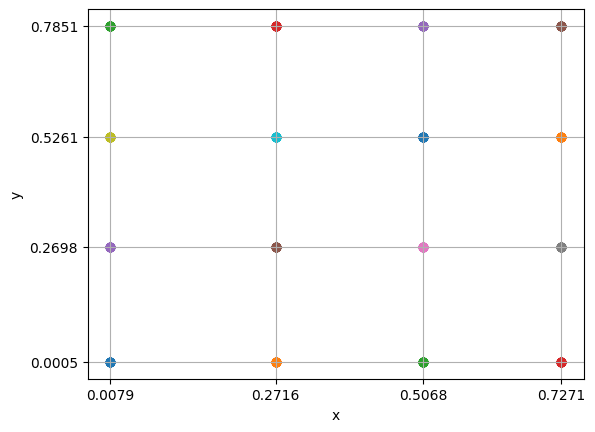

In [10]:

def shift_feature_to_value(data: ndarray, column: int, value: float):
    mod_data = data.copy()
    mod_data[:, column] = value
    return mod_data

fig, ax = plt.subplots()
ax.set_xticks(grid[0])
ax.set_xlabel("x")
ax.set_yticks(grid[1])
ax.set_ylabel("y")
ax.grid()

def shift(packed_data, columns, bins):
    for row_idx, column in enumerate(packed_data):
        for column_idx, cell in enumerate(column):
            upper = shift_feature_to_value(cell.copy(), columns[1], bins[1, row_idx + 1])
            lower = shift_feature_to_value(cell.copy(), columns[1], bins[1, row_idx])

            upper_right = shift_feature_to_value(upper.copy(), columns[0], bins[0, column_idx + 1])
            upper_left = shift_feature_to_value(upper.copy(), columns[0], bins[0, column_idx])

            lower_right = shift_feature_to_value(lower.copy(), columns[0], bins[0, column_idx + 1])
            lower_left = shift_feature_to_value(lower.copy(), columns[0], bins[0, column_idx])

            ax.scatter(*lower_left.T)

shift(packed_data, [0, 1], grid)